## Import libraries and setup

In [1]:
import pandas as pd
import numpy as np
import re


## Load data and Preview first row 

In [2]:

df = pd.read_csv("immovlan_final_file.csv")
df.head()

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Type of heating,Type of glazing,Elevator,Number of facades,Garden,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool
0,https://immovlan.be/en/detail/studio/for-sale/...,vbd20021,175 000 €,New,On contract,0.0,51 m²,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,NaN
1,https://immovlan.be/en/detail/apartment/for-sa...,vbd30235,415 000 €,New,On contract,1.0,70 m²,No,NaN,Yes,...,NaN,NaN,Yes,2.0,Yes,NaN,Yes,20 m²,NaN,Yes
2,https://immovlan.be/en/detail/residence/for-sa...,vbd46297,399 000 €,NaN,NaN,2.0,129 m²,NaN,NaN,Yes,...,Gas,Double glass,NaN,4.0,Yes,NaN,NaN,NaN,NaN,NaN
3,https://immovlan.be/en/detail/apartment/for-sa...,vbd36813,229 000 €,New,NaN,2.0,82 m²,NaN,NaN,NaN,...,NaN,NaN,Yes,3.0,No,NaN,Yes,8 m²,NaN,NaN
4,https://immovlan.be/en/detail/apartment/for-sa...,vbb60643,320 000 €,New,NaN,3.0,106 m²,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,NaN,Yes,6 m²,NaN,NaN


## Check duplicates rows and unique value IDs 

In [3]:
# check 1: Duplicate rows 
duplicate_rows = df.duplicated().sum()
print(f"\n1. Exact duplicate rows: {duplicate_rows}")

# check 2: Duplicate property IDs
if 'Property ID' in df.columns:
    duplicate_ids = df['Property ID'].duplicated().sum()
    print(f"2. Duplicate Property IDs: {duplicate_ids}")

duplicate_remove = df.drop_duplicates()
print(duplicate_remove.shape)


1. Exact duplicate rows: 0
2. Duplicate Property IDs: 0
(16309, 26)


## Check for whitespace - 

lambda x: isinstance(x, str) and x != x.strip()
For each cell x in the DataFrame:
isinstance(x, str) → checks if the cell contains a string.
x.strip() → removes leading/trailing whitespace.
x != x.strip() → will be True if trimming changes the value (i.e., whitespace existed).

In [4]:
has_whitespace = df.map(lambda x: isinstance(x, str) and x != x.strip()).any().any()
print("Contains whitespace?", has_whitespace)

Contains whitespace? False


## Check Data Types

In [5]:
# df.dtypes

df.info(show_counts=True, memory_usage=True, verbose=True)
df_obj = df.select_dtypes(include=['object'])
print(df_obj.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    16309 non-null  object 
 1   Property ID            16309 non-null  object 
 2   Price                  15725 non-null  object 
 3   State of the property  11846 non-null  object 
 4   Availability           7001 non-null   object 
 5   Number of bedrooms     14083 non-null  float64
 6   Livable surface        13294 non-null  object 
 7   Furnished              8383 non-null   object 
 8   Attic                  3661 non-null   object 
 9   Garage                 7044 non-null   object 
 10  Number of garages      3799 non-null   float64
 11  Kitchen equipment      4380 non-null   object 
 12  Kitchen type           2181 non-null   object 
 13  Number of bathrooms    12042 non-null  float64
 14  Number of showers      3538 non-null   float64
 15  Nu

## Fixing columns which are numbers but shown as object 

Price                   object  ❌ Has "€" symbol
Livable surface         object  ❌ Has "m²" unit
Surface garden          object  ❌ Has "m²" unit

In [6]:
# ============================================
# STEP 1: Define cleaning function
# ============================================

def clean_numeric(value):
    """Universal numeric cleaner"""
    if pd.isna(value):
        return np.nan
    
    value = str(value)
    value = re.sub(r'[€$£,\s]', '', value)   # Remove currency, commas, spaces
    value = re.sub(r'm²?', '', value)         # Remove m² or m
    value = re.sub(r'[a-zA-Z]', '', value)    # Remove letters
    
    try:
        return float(value)
    except:
        return np.nan

# ============================================
# STEP 2: Apply to columns
# ============================================

columns = ['Price', 'Livable surface', 'Surface garden','Surface terrace', 'Total land surface']

for col in columns:
    if col in df.columns:
        # Before
        before_type = df[col].dtype
        before_sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
        
        # Clean
        df[col] = df[col].apply(clean_numeric)
        
        # After
        after_type = df[col].dtype
        after_sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
        
    # Report
        print(f"\n✓ {col}:")
        print(f"    {before_type} → {after_type}")
        print(f"    '{before_sample}' → {after_sample}")     


✓ Price:
    object → float64
    '175 000 €' → 175000.0



✓ Livable surface:
    object → float64
    '51 m²' → 51.0

✓ Surface garden:
    object → float64
    '315 m²' → 315.0

✓ Surface terrace:
    object → float64
    '20 m²' → 20.0

✓ Total land surface:
    object → float64
    '320 m²' → 320.0


## Convert yes and no values to 1, 0

In [7]:
yes_or_no_columns = ["Furnished", "Attic", "Garage", "Elevator", "Garden", "Terrace", "Swimming pool"]

for column in yes_or_no_columns:
    if column in df.columns:
        df[column] = (      
            df[column]
            .astype(str)                     # make sure everything is text
            .str.strip()                     # remove spaces
            .str.lower()                     # make all text lowercase
            .map({
                "yes": 1, "y": 1, "true": 1, "1": 1,
                "no": 0, "n": 0, "false": 0, "0": 0
            })
        )
display(df[yes_or_no_columns].head(20))

,Furnished,Attic,Garage,Elevator,Garden,Terrace,Swimming pool
0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,0.0,NaN,1.0,1.0,1.0,1.0,1.0
2,NaN,NaN,1.0,NaN,1.0,NaN,NaN
3,NaN,NaN,NaN,1.0,0.0,1.0,NaN
4,NaN,NaN,NaN,NaN,1.0,1.0,NaN
5,0.0,NaN,NaN,1.0,0.0,1.0,NaN
6,0.0,1.0,1.0,0.0,1.0,1.0,NaN
7,0.0,NaN,NaN,NaN,1.0,1.0,NaN
8,NaN,NaN,NaN,1.0,0.0,1.0,NaN
9,0.0,1.0,1.0,0.0,1.0,1.0,0.0


## Checking for missing values

In [8]:

missing_count = df.isnull().sum()
display(missing_count)

url                          0
Property ID                  0
Price                      584
State of the property     4463
Availability              9308
Number of bedrooms        2226
Livable surface           3015
Furnished                 7926
Attic                    12648
Garage                    9265
Number of garages        12510
Kitchen equipment        11929
Kitchen type             14128
Number of bathrooms       4267
Number of showers        12771
Number of toilets         6295
Type of heating           6966
Type of glazing           9232
Elevator                  5486
Number of facades         6492
Garden                    3523
Surface garden           13578
Terrace                   2721
Surface terrace           8861
Total land surface        9319
Swimming pool            12389
dtype: int64

## Replace missing values by Nan

In [9]:
# Replace empty strings with pd.NA
df = df.replace("", pd.NA)

# Convert all columns to object type to allow string "nan"
df = df.astype(object)

# Fill missing values with string "nan"
df = df.fillna("nan")

display(df)

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Type of heating,Type of glazing,Elevator,Number of facades,Garden,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool
0,https://immovlan.be/en/detail/studio/for-sale/...,vbd20021,175000.0,New,On contract,0.0,51.0,nan,nan,nan,...,nan,nan,nan,nan,0.0,nan,0.0,nan,nan,nan
1,https://immovlan.be/en/detail/apartment/for-sa...,vbd30235,415000.0,New,On contract,1.0,70.0,0.0,nan,1.0,...,nan,nan,1.0,2.0,1.0,nan,1.0,20.0,nan,1.0
2,https://immovlan.be/en/detail/residence/for-sa...,vbd46297,399000.0,nan,nan,2.0,129.0,nan,nan,1.0,...,Gas,Double glass,nan,4.0,1.0,nan,nan,nan,nan,nan
3,https://immovlan.be/en/detail/apartment/for-sa...,vbd36813,229000.0,New,nan,2.0,82.0,nan,nan,nan,...,nan,nan,1.0,3.0,0.0,nan,1.0,8.0,nan,nan
4,https://immovlan.be/en/detail/apartment/for-sa...,vbb60643,320000.0,New,nan,3.0,106.0,nan,nan,nan,...,nan,nan,nan,nan,1.0,nan,1.0,6.0,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16304,https://immovlan.be/en/detail/villa/for-sale/1...,vwd15514,995000.0,Excellent,On contract,6.0,300.0,nan,nan,1.0,...,Not specified,nan,nan,4.0,1.0,750.0,1.0,20.0,1448.0,1.0
16305,https://immovlan.be/en/detail/investment-prope...,rbu64401,645000.0,nan,nan,4.0,nan,nan,nan,1.0,...,nan,nan,nan,nan,nan,nan,1.0,nan,213.0,nan
16306,https://immovlan.be/en/detail/investment-prope...,rbt71588,649000.0,Normal,nan,5.0,nan,nan,nan,nan,...,Gas,nan,0.0,2.0,nan,nan,nan,nan,110.0,nan
16307,https://immovlan.be/en/detail/apartment/for-sa...,rbu61550,239000.0,nan,On contract,2.0,100.0,0.0,nan,1.0,...,Electricity,nan,1.0,nan,0.0,nan,0.0,nan,nan,nan


Extract information from URLs 

In [10]:
# Extract the parts
df[['type', 'postal_code', 'city']] = df['url'].str.extract(
    r'detail/([^/]+)/for-sale/(\d+)/([^/]+)/'
)

print(df[['type', 'postal_code', 'city']])


                      type postal_code               city
0                   studio        4000              liege
1                apartment        1410           waterloo
2                residence        1501          buizingen
3                apartment        7000               mons
4                apartment        7000               mons
...                    ...         ...                ...
16304                villa        1440  braine-le-chateau
16305  investment-property        2530           boechout
16306  investment-property        8600          diksmuide
16307            apartment        2630         aartselaar
16308            apartment        8630             veurne

[16309 rows x 3 columns]


## Save cleaned data into new file 

In [11]:
df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")
df.head(1)



,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Number of facades,Garden,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool,type,postal_code,city
0,https://immovlan.be/en/detail/studio/for-sale/...,vbd20021,175000.0,New,On contract,0.0,51.0,nan,nan,nan,...,nan,0.0,nan,0.0,nan,nan,nan,studio,4000,liege


## Create dataframe on type using two categories - Businesses and Land 

In [12]:
df = pd.read_csv("immovlan_cleaned_file.csv")
# Clean up the 'type' column
df['type'] = df['type'].str.lower().str.replace('-', ' ').str.strip()         # removes spaces and capitalizes words
df["type"].unique()                      # display list from column 

# Define subcategories
business_types = ['commercial building', 'industrial building', 'office space', 'business surface']
land_types = ['land', 'development site', 'to parcel out site']

# Filter rows where 'type' matches any of the business or land subcategories
property_df = df[df['type'].isin(business_types + land_types)]

# Preview
display(property_df['type'].value_counts())
display(property_df.head())



type
land                   642
commercial building    439
development site       394
industrial building    172
office space           123
business surface        45
to parcel out site      17
Name: count, dtype: int64

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Number of facades,Garden,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool,type,postal_code,city
21,https://immovlan.be/en/detail/commercial-build...,rbu66908,150000.0,NaN,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,34.0,NaN,NaN,commercial building,1800,vilvoorde
24,https://immovlan.be/en/detail/land/for-sale/69...,vbd36859,75000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,694.0,NaN,land,6950,nassogne
33,https://immovlan.be/en/detail/land/for-sale/96...,rbu60077,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1514.0,NaN,land,9600,ronse
35,https://immovlan.be/en/detail/commercial-build...,rbu50976,499000.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,345.0,NaN,commercial building,1570,galmaarden
37,https://immovlan.be/en/detail/land/for-sale/62...,vbd49230,65000.0,NaN,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,460.0,NaN,land,6230,pont-a-celles


## Regions 
A. Deterministic postcode -> region mapping 

In [13]:
def postcode_to_region(pc):
    if pd.isna(pc):
        return "Unknown"
    pc = int(pc)

    # Brussels
    if 1000 <= pc <= 1299:
        return "Brussels"

    # Wallonia
    if 1300 <= pc <= 1499:
        return "Wallonia"
    if 4000 <= pc <= 7999:
        return "Wallonia"

    # Flanders
    if 1500 <= pc <= 3999:
        return "Flanders"
    if 8000 <= pc <= 9999:
        return "Flanders"

    return "Unknown"

df["Region"] = df["postal_code"].apply(postcode_to_region)

# Test 
print("Region distribution:")
print(df["Region"].value_counts(dropna=False))

df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")

Region distribution:
Region
Wallonia    8142
Flanders    6724
Brussels    1443
Name: count, dtype: int64


B. Map postcode to province

In [14]:
provinces = {
    "brussels": list(range(1000, 1300)),
    "brabant_walloon": list(range(1300, 1500)),
    "brabant_flemish": list(range(1500, 2000)) + list(range(3000, 3500)),
    "antwerp": list(range(2000, 3000)),
    "limburg": list(range(3500, 4000)),
    "liege": list(range(4000, 4500)),
    "namur": list(range(4500, 5681)),
    "hainaut": list(range(5681, 6600)) + list(range(7000, 8000)),
    "luxembourg": list(range(6600, 7000)),
    "west_flanders": list(range(8000, 9000)),
    "east_flanders": list(range(9000, 10000))
}
def postcode_to_province(postcode):
    # Brussels
    if postcode in provinces["brussels"]:
        return "Brussels"
    # Walloon Brabant
    if postcode in provinces["brabant_walloon"]:
        return "Walloon Brabant"
    # Flemish Brabant
    if postcode in provinces["brabant_flemish"]:
        return "Flemish Brabant"
    # Antwerp
    if postcode in provinces["antwerp"]:
        return "Antwerp"
    # Limburg
    if postcode in provinces["limburg"]:
        return "Limburg"

    # Liege
    if postcode in provinces["liege"]:
        return "Liege"

    # Namur
    if postcode in provinces["namur"]:
        return "Namur"

    # Hainaut
    if postcode in provinces["hainaut"]:
        return "Hainaut"

    # Luxembourg
    if postcode in provinces["luxembourg"]:
        return "Luxembourg"

    # West Flanders
    if postcode in provinces["west_flanders"]:
        return "West Flanders"

    # East Flanders
    if postcode in provinces["east_flanders"]:
        return "East Flanders"

    return "Unknown"

df["province"] = df["postal_code"].apply(postcode_to_province)

# Test
print("Provinces distribution:")
print(df["province"].value_counts(dropna=False))

df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")

Provinces distribution:
province
Namur              2447
Walloon Brabant    1625
Hainaut            1503
Limburg            1502
Brussels           1443
Antwerp            1408
Luxembourg         1387
West Flanders      1293
Flemish Brabant    1283
East Flanders      1238
Liege              1180
Name: count, dtype: int64


## Calculate area per meter square

In [15]:
df["price_per_sqm"] = df["Price"] / df["Livable surface"]
df['Price_per_sqm_land'] = df['Price'] / df['Total land surface']

df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")

## Visualization  

In [16]:
import plotly.express as px

print("="*70)
print("📊 BOX PLOT: Price Distribution by Province")
print("="*70)

# Remove missing prices and provinces
df_plot = df[df['Price'].notna() & df['province'].notna()].copy()

# Create interactive box plot
fig = px.box(
    df_plot, 
    x='province', 
    y='Price',
    title='Property Prices by Province',
    labels={'Price': 'Price (€)', 'province': 'Province', 'type': 'Property type'},
    color='province',  # Different color for each province
    hover_data=['Price','type']  # Show price on hover
)

# Customize layout
fig.update_layout(
    height=600,
    xaxis_tickangle=-45,  # Rotate labels
    showlegend=True,
    font=dict(size=12)
)

# Format y-axis as currency
fig.update_yaxes(tickformat='€,.0f')

fig.show()

print(f"\n✓ Displaying {len(df_plot)} properties across {df_plot['province'].nunique()} provinces")


📊 BOX PLOT: Price Distribution by Province



✓ Displaying 15725 properties across 11 provinces


In [17]:
import plotly.graph_objects as go 


print("="*70)
print("📊 BAR CHART: Average Price by Province")
print("="*70)

# Calculate average price per province
avg_prices = df.groupby('province')['Price'].agg(['mean', 'median', 'count']).reset_index()
avg_prices = avg_prices.sort_values('mean', ascending=False)

print("\nAverage Prices by Province:")
print(avg_prices)

# Create bar chart
fig = go.Figure()

# Add bars for mean price
fig.add_trace(go.Bar(
    x=avg_prices['province'],
    y=avg_prices['mean'],
    name='Average Price',
    text=avg_prices['mean'].apply(lambda x: f'€{x:,.0f}'),
    textposition='outside',
    marker_color='lightblue',
    hovertemplate='<b>%{x}</b><br>Average: €%{y:,.0f}<extra></extra>'
))

# Add bars for median price
fig.add_trace(go.Bar(
    x=avg_prices['province'],
    y=avg_prices['median'],
    name='Median Price',
    text=avg_prices['median'].apply(lambda x: f'€{x:,.0f}'),
    textposition='outside',
    marker_color='lightcoral',
    hovertemplate='<b>%{x}</b><br>Median: €%{y:,.0f}<extra></extra>'
))

fig.update_layout(
    title='Average vs Median Price by Province',
    xaxis_title='Province',
    yaxis_title='Price (€)',
    barmode='group',  # Side-by-side bars
    height=600,
    xaxis_tickangle=-45,
    hovermode='x unified'
)

fig.update_yaxes(tickformat='€,.0f')

fig.show()

print(f"\n✓ Chart created for {len(avg_prices)} provinces")

📊 BAR CHART: Average Price by Province

Average Prices by Province:
           province           mean    median  count
1          Brussels  548583.616725  429000.0   1435
3   Flemish Brabant  496121.361582  414904.0   1239
2     East Flanders  448566.978723  385000.0   1222
9   Walloon Brabant  442028.372281  385000.0   1609
0           Antwerp  385367.681492  335000.0   1394
10    West Flanders  364727.584712  319500.0   1269
6           Limburg  348713.569952  325000.0   1451
8             Namur  301085.254366  279500.0   2233
7        Luxembourg  301006.332064  275000.0   1313
5             Liege  289565.280215  275000.0   1117
4           Hainaut  259911.762994  232400.0   1443



✓ Chart created for 11 provinces


In [18]:
from plotly.subplots import make_subplots

print("="*70)
print("📊 DASHBOARD: Comprehensive Province Analysis")
print("="*70)

df_plot = df[df['Price'].notna() & df['province'].notna()].copy()

# Calculate statistics
stats = df_plot.groupby('province').agg({
    'Price': ['mean', 'median', 'count', 'min', 'max']
}).round(0)

stats.columns = ['Mean', 'Median', 'Count', 'Min', 'Max']
stats = stats.reset_index().sort_values('Mean', ascending=False)

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Average Price by Province',
        'Property Count by Province',
        'Price Range (Min-Max)',
        'Mean vs Median Price'
    ),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]]
)

# 1. Average Price
fig.add_trace(
    go.Bar(x=stats['province'], y=stats['Mean'], name='Avg Price', marker_color='lightblue'),
    row=1, col=1
)

# 2. Property Count
fig.add_trace(
    go.Bar(x=stats['province'], y=stats['Count'], name='Count', marker_color='lightgreen'),
    row=1, col=2
)

# 3. Price Range
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Min'], mode='markers', 
               name='Min', marker=dict(size=10, color='red')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Max'], mode='markers', 
               name='Max', marker=dict(size=10, color='green')),
    row=2, col=1
)

# 4. Mean vs Median
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Mean'], mode='lines+markers',
               name='Mean', line=dict(color='blue')),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Median'], mode='lines+markers',
               name='Median', line=dict(color='red')),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=900,
    showlegend=True,
    title_text="Province Price Analysis Dashboard"
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=-45)

fig.show()

print(f"\n✓ Dashboard created with {len(stats)} provinces")

📊 DASHBOARD: Comprehensive Province Analysis



✓ Dashboard created with 11 provinces


### Map of belgium with median price per province

In [19]:
# Aggregate the median price and number of observations of each province in a Dataframe

province_median_summary = df.groupby("province")["Price"].agg(median_price="median", n_obs="count").reset_index()
province_median_summary.index += 1
province_mean_summary = df.groupby("province")["Price"].agg(mean_price="mean", n_obs="count").reset_index().round(2)
province_mean_summary.index += 1

#Optional
display(province_median_summary)
display(province_mean_summary)

,province,median_price,n_obs
1,Antwerp,335000.0,1394
2,Brussels,429000.0,1435
3,East Flanders,385000.0,1222
4,Flemish Brabant,414904.0,1239
5,Hainaut,232400.0,1443
6,Liege,275000.0,1117
7,Limburg,325000.0,1451
8,Luxembourg,275000.0,1313
9,Namur,279500.0,2233
10,Walloon Brabant,385000.0,1609


,province,mean_price,n_obs
1,Antwerp,385367.68,1394
2,Brussels,548583.62,1435
3,East Flanders,448566.98,1222
4,Flemish Brabant,496121.36,1239
5,Hainaut,259911.76,1443
6,Liege,289565.28,1117
7,Limburg,348713.57,1451
8,Luxembourg,301006.33,1313
9,Namur,301085.25,2233
10,Walloon Brabant,442028.37,1609


In [20]:
# Shapefile (map) that matches the provinces (with GeoJSON or shapefile)

import geopandas as gpd

# Natural Earth “Admin 1 – States, Provinces” shapefile for Belgium
url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_10m_admin_1_states_provinces.geojson"
provinces_map = gpd.read_file(url).query("iso_a2 == 'BE'")



# Testing: list the columns that contains province names
print(provinces_map[["name", "name_en"]])

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
# Load the map and harmonise province names

# Load Natural-Earth provinces in Belgium
provinces_map = gpd.read_file(url).query("iso_a2 == 'BE'")[["name_en", "geometry"]]

# Rename column to match our data
provinces_map = provinces_map.rename(columns={"name_en": "province"})

# Spelling fixes so names == province_summary
name_fix = {
    "Liège": "Liege",
    "Brussels Capital": "Brussels",
}
provinces_map["province"] = provinces_map["province"].replace(name_fix)

# Testing
print("Mapped provinces:", sorted(provinces_map["province"].unique()))
print("Data provinces:", sorted(province_median_summary["province"].unique()))

Mapped provinces: ['Antwerp', 'Brussels', 'East Flanders', 'Flemish Brabant', 'Hainaut', 'Liege', 'Limburg', 'Luxembourg', 'Namur', 'Walloon Brabant', 'West Flanders']
Data provinces: ['Antwerp', 'Brussels', 'East Flanders', 'Flemish Brabant', 'Hainaut', 'Liege', 'Limburg', 'Luxembourg', 'Namur', 'Walloon Brabant', 'West Flanders']


In [ ]:
# Merge price data into the map

# Left join so every province polygon gets its median price and observation count
provinces_map_median = provinces_map.merge(province_median_summary, on="province", how="left")
provinces_map_mean = provinces_map.merge(province_mean_summary, on="province", how="left")

# Testing

# Median
display(provinces_map_median.head())
display(provinces_map_median[["province", "median_price", "n_obs"]].sort_values("median_price"))

# Mean
display(provinces_map_mean.head())
display(provinces_map_mean[["province", "mean_price", "n_obs"]].sort_values("mean_price"))

,province,geometry,median_price,n_obs
0,West Flanders,"POLYGON ((2.65062 50.81225, 2.64245 50.81246, ...",319500.0,1269
1,Hainaut,"MULTIPOLYGON (((2.88688 50.69665, 2.87128 50.6...",232400.0,1443
2,Namur,"POLYGON ((4.83136 50.1434, 4.8201 50.14645, 4....",279500.0,2233
3,Luxembourg,"POLYGON ((5.19248 49.68281, 5.16943 49.6872, 5...",275000.0,1313
4,Liege,"POLYGON ((6.03863 50.14841, 6.02736 50.14945, ...",275000.0,1117


,province,median_price,n_obs
1,Hainaut,232400.0,1443
3,Luxembourg,275000.0,1313
4,Liege,275000.0,1117
2,Namur,279500.0,2233
0,West Flanders,319500.0,1269
7,Limburg,325000.0,1451
6,Antwerp,335000.0,1394
5,East Flanders,385000.0,1222
10,Walloon Brabant,385000.0,1609
9,Flemish Brabant,414904.0,1239


,province,geometry,mean_price,n_obs
0,West Flanders,"POLYGON ((2.65062 50.81225, 2.64245 50.81246, ...",364727.58,1269
1,Hainaut,"MULTIPOLYGON (((2.88688 50.69665, 2.87128 50.6...",259911.76,1443
2,Namur,"POLYGON ((4.83136 50.1434, 4.8201 50.14645, 4....",301085.25,2233
3,Luxembourg,"POLYGON ((5.19248 49.68281, 5.16943 49.6872, 5...",301006.33,1313
4,Liege,"POLYGON ((6.03863 50.14841, 6.02736 50.14945, ...",289565.28,1117


,province,mean_price,n_obs
1,Hainaut,259911.76,1443
4,Liege,289565.28,1117
3,Luxembourg,301006.33,1313
2,Namur,301085.25,2233
7,Limburg,348713.57,1451
0,West Flanders,364727.58,1269
6,Antwerp,385367.68,1394
10,Walloon Brabant,442028.37,1609
5,East Flanders,448566.98,1222
9,Flemish Brabant,496121.36,1239


In [ ]:
# Median price per province map with interactive tool-tips

import folium, json

# centre on Belgium
m = folium.Map(location=[50.5, 4.5], zoom_start=8)

# build the choropleth
folium.Choropleth(
    geo_data=provinces_map_median.to_json(),
    data=provinces_map_median,
    columns=["province", "median_price"],
    key_on="feature.properties.province",
    fill_color="YlGn",
    nan_fill_color="grey",
    legend_name="Median price (€)"
).add_to(m)

# add hover tool-tips
from folium import features

tooltip = features.GeoJsonTooltip(
    fields=["province", "median_price", "n_obs"],
    aliases=["Province:", "Median price (€):", "Observations:"],
    localize=True
)

features.GeoJson(
    provinces_map_median.to_json(),
    tooltip=tooltip,
    style_function=lambda x: {"fillOpacity": 0, "weight": 0}
).add_to(m)

m

In [ ]:
# Mean price per province map with interactive tool-tips

# centre on Belgium
m = folium.Map(location=[50.5, 4.5], zoom_start=8)

# build the choropleth
folium.Choropleth(
    geo_data=provinces_map_mean.to_json(),
    data=provinces_map_mean,
    columns=["province", "mean_price"],
    key_on="feature.properties.province",
    fill_color="YlGn",
    nan_fill_color="grey",
    legend_name="Mean price (€)"
).add_to(m)

# add hover tool-tips
from folium import features

tooltip = features.GeoJsonTooltip(
    fields=["province", "mean_price", "n_obs"],
    aliases=["Province:", "Mean price (€):", "Observations:"],
    localize=True
)

features.GeoJson(
    provinces_map_mean.to_json(),
    tooltip=tooltip,
    style_function=lambda x: {"fillOpacity": 0, "weight": 0}
).add_to(m)

m

# Apartments

## Creating apartments DataFrame:

In [ ]:
df =  pd.read_csv("immovlan_cleaned_file.csv", encoding="utf-8")

In [ ]:
apartments = df[df["type"].isin(["apartment", "ground floor", "penthouse", "studio", "duplex", "loft", "triplex"])]

apartments.head(10)

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool,type,postal_code,city,Region,province
0,https://immovlan.be/en/detail/studio/for-sale/...,vbd20021,175000.0,New,On contract,0.0,51.0,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,studio,4000,liege,Wallonia,Liege
1,https://immovlan.be/en/detail/apartment/for-sa...,vbd30235,415000.0,New,On contract,1.0,70.0,0.0,NaN,1.0,...,NaN,1.0,20.0,NaN,1.0,apartment,1410,waterloo,Wallonia,Walloon Brabant
3,https://immovlan.be/en/detail/apartment/for-sa...,vbd36813,229000.0,New,NaN,2.0,82.0,NaN,NaN,NaN,...,NaN,1.0,8.0,NaN,NaN,apartment,7000,mons,Wallonia,Hainaut
4,https://immovlan.be/en/detail/apartment/for-sa...,vbb60643,320000.0,New,NaN,3.0,106.0,NaN,NaN,NaN,...,NaN,1.0,6.0,NaN,NaN,apartment,7000,mons,Wallonia,Hainaut
5,https://immovlan.be/en/detail/apartment/for-sa...,vbd46661,185000.0,Excellent,NaN,1.0,56.0,0.0,NaN,NaN,...,NaN,1.0,7.0,NaN,NaN,apartment,1400,nivelles,Wallonia,Walloon Brabant
7,https://immovlan.be/en/detail/apartment/for-sa...,vbd48568,NaN,New,NaN,4.0,167.0,0.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,apartment,1300,wavre,Wallonia,Walloon Brabant
8,https://immovlan.be/en/detail/apartment/for-sa...,vbd36992,329000.0,New,NaN,3.0,113.0,NaN,NaN,NaN,...,NaN,1.0,9.0,NaN,NaN,apartment,1480,tubize,Wallonia,Walloon Brabant
11,https://immovlan.be/en/detail/apartment/for-sa...,vbd46746,679000.0,New,On contract,3.0,150.0,NaN,NaN,NaN,...,NaN,1.0,6.0,NaN,0.0,apartment,1170,watermaal-bosvoorde,Brussels,Brussels
12,https://immovlan.be/en/detail/apartment/for-sa...,rbt86438,224250.0,New,NaN,1.0,71.0,NaN,0.0,1.0,...,NaN,1.0,NaN,NaN,0.0,apartment,8900,ieper,Flanders,West Flanders
13,https://immovlan.be/en/detail/apartment/for-sa...,vbd34109,229900.0,Excellent,Immediately,2.0,77.0,0.0,NaN,1.0,...,NaN,0.0,NaN,NaN,0.0,apartment,6790,aubange,Wallonia,Luxembourg


## Dataset Overview:

In [ ]:
print("Shape:", apartments.shape)

# Summary info
apartments.info()

# Missing values
missing = apartments.isna().mean().sort_values(ascending=False) * 100
print("Missing values (%):")
print(missing)

Shape: (7396, 31)
<class 'pandas.core.frame.DataFrame'>
Index: 7396 entries, 0 to 16308
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    7396 non-null   object 
 1   Property ID            7396 non-null   object 
 2   Price                  7008 non-null   float64
 3   State of the property  5903 non-null   object 
 4   Availability           2251 non-null   object 
 5   Number of bedrooms     7257 non-null   float64
 6   Livable surface        7196 non-null   float64
 7   Furnished              4488 non-null   float64
 8   Attic                  399 non-null    float64
 9   Garage                 3059 non-null   float64
 10  Number of garages      1049 non-null   float64
 11  Kitchen equipment      2359 non-null   object 
 12  Kitchen type           864 non-null    object 
 13  Number of bathrooms    5875 non-null   float64
 14  Number of showers      1621 non-null   flo

## Removing columns that has too many missing values:

In [ ]:
columns_to_remove = missing[missing > 87].index.tolist()
print("Columns recommended for removal:", columns_to_remove)
apartments = apartments.drop(columns=columns_to_remove)
apartments.info()
apartments.shape

Columns recommended for removal: ['Total land surface', 'Attic', 'Surface garden', 'Kitchen type']
<class 'pandas.core.frame.DataFrame'>
Index: 7396 entries, 0 to 16308
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    7396 non-null   object 
 1   Property ID            7396 non-null   object 
 2   Price                  7008 non-null   float64
 3   State of the property  5903 non-null   object 
 4   Availability           2251 non-null   object 
 5   Number of bedrooms     7257 non-null   float64
 6   Livable surface        7196 non-null   float64
 7   Furnished              4488 non-null   float64
 8   Garage                 3059 non-null   float64
 9   Number of garages      1049 non-null   float64
 10  Kitchen equipment      2359 non-null   object 
 11  Number of bathrooms    5875 non-null   float64
 12  Number of showers      1621 non-null   float64
 13  Number of toi

(7396, 27)

## Qualitative and quantitative variables
Quantitative variables:<br>
Use visuals that show distribution:<br>
-Histogram <br>
-Boxplot<br>
-Scatterplot<br>
-Density plots<br>
-Heatmap (correlation matrix)<br>
-Violin plots<br>

Qualitative variables:<br>
Use visuals that compare counts or group statistics:<br>
-Bar charts (counts)<br>
-Bar charts of mean price per category<br>
-Stacked bar charts<br>
-Pie charts (rarely recommended)<br>

In [ ]:
qual_vars = apartments.select_dtypes(include=['object']).columns
quant_vars = apartments.select_dtypes(include=['float64','int64']).columns

len(qual_vars), len(quant_vars)

(11, 16)

Appropriate correlation measures <br>
Data Type	 -  Recommended Correlation<br>
Quantitative ↔ Quantitative	Pearson, Spearman<br>
Qualitative ↔ Qualitative	Cramér’s V, Chi-square<br>
Quantitative ↔ Qualitative	ANOVA F-value, point-biserial (if binary), Mutual Information<br>
When to use what:<br>
Pearson: linear relationships<br>
Spearman: monotonic but non-linear<br>
Cramér's V: relationship strength between categories<br>
Mutual Information: great for mixed data types

## Distribution analysis:

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

## Price Distribution:

In [ ]:
import plotly.express as px

fig = px.box(
    apartments,
    y="Price",
    points="all",   # show all points
    title="Distribution of Apartment Prices with Outliers",
    labels={"Price": "Price (€)"},
    template="plotly_white"
)

fig.show()


## Checking for smalles values

In [ ]:
apartments[["type", "Price", "city"]].sort_values(by="Price").head(20)


,type,Price,city
7994,apartment,1.0,hechtel
11188,apartment,1.0,hechtel
4920,apartment,1.0,hechtel
7002,apartment,1.0,hechtel
7076,apartment,1.0,hechtel
5630,apartment,1.0,hechtel
10654,apartment,1.0,veurne
16273,apartment,1.0,hechtel
8169,duplex,25000.0,vielsalm
13444,apartment,39900.0,baronville


## Dropping values with 1 EUR
(some of them are part of the project that we later included in our list, scams or typos)

In [ ]:
apartments = apartments.drop(apartments[apartments["Price"] == 1].index).copy()
apartments[["type", "Price", "city"]].sort_values(by="Price").head(20)


,type,Price,city
8169,duplex,25000.0,vielsalm
13444,apartment,39900.0,baronville
15762,studio,49000.0,charleroi
12288,penthouse,50000.0,huy
3773,duplex,55000.0,modave
5469,apartment,55000.0,membre
926,apartment,59000.0,grand-halleux
15561,apartment,60000.0,durbuy
9580,studio,65000.0,namur
14500,apartment,69000.0,chatelet


## Checking for largest values

In [ ]:
apartments[["type", "Price", "city"]].sort_values(by="Price", ascending=False).head(20)

,type,Price,city
3445,penthouse,2373750.0,oostende
14731,apartment,2035000.0,la-hulpe
2932,penthouse,1950000.0,antwerp
3778,penthouse,1895000.0,sint-lambrechts-woluwe
4521,penthouse,1895000.0,sint-lambrechts-woluwe
11770,penthouse,1890000.0,sterrebeek
9303,apartment,1875000.0,la-hulpe
2392,apartment,1850000.0,sint-lambrechts-woluwe
4963,apartment,1850000.0,sint-lambrechts-woluwe
2571,apartment,1850000.0,sint-lambrechts-woluwe


# Distribution of apartment prices

In [ ]:
import plotly.express as px

fig = px.box(
    apartments,
    y="Price",
    points="all",   # show all points
    title="Distribution of Apartment Prices",
    labels={"Price": "Price (€)"},
    template="plotly_white"
)

fig.show()

# Distribution of apartment types:

In [ ]:
import plotly.express as px

# Count each apartment type
type_counts = apartments["type"].value_counts()

fig = px.bar(
    x=type_counts.index,
    y=type_counts.values,
    title="Distribution of Apartment Types",
    labels={"x": "Apartment Type", "y": "Count"},
    template="plotly_white"
)
fig.show()




## Using log scale to see better:

In [ ]:
#USE THIS ONE
import plotly.graph_objects as go

type_counts = apartments["type"].value_counts()

fig = go.Figure()

# Bar chart WITH LABELS
fig.add_trace(go.Bar(
    x=type_counts.index,
    y=type_counts.values,
    name="Count",
    text=type_counts.values,         # show counts on bars
    textposition="outside",          # place above the bars
    textfont=dict(size=12)
))

fig.update_layout(
    title="Distribution of Apartment Types (Log Scale)",
    xaxis_title="Apartment Type",
    yaxis_title="Count",
    template="plotly_white"
)

fig.update_yaxes(type="log")

fig.show()



## Surface Distribution


## Cheking for smallest values:

In [ ]:
apartments[["type", "Livable surface", "city", "province"]].sort_values(by="Livable surface").head(20)


,type,Livable surface,city,province
4577,studio,12.0,elsene,Brussels
5540,studio,12.0,mons,Hainaut
177,studio,12.0,mons,Hainaut
10078,studio,12.0,elsene,Brussels
5584,studio,13.0,mons,Hainaut
14253,studio,13.0,elsene,Brussels
10897,studio,13.0,mons,Hainaut
1842,studio,13.0,elsene,Brussels
15061,studio,13.0,mons,Hainaut
5844,studio,13.0,elsene,Brussels


## Checking for largest values:

In [ ]:
apartments[["type", "Livable surface", "city", "province"]].sort_values(by="Livable surface", ascending=False).head(20)

,type,Livable surface,city,province
6265,penthouse,421300.0,liege,Liege
7981,apartment,818.0,angleur,Liege
14885,studio,800.0,tournai,Hainaut
7104,apartment,766.0,angleur,Liege
2399,apartment,600.0,laken,Brussels
792,apartment,530.0,beerse,Antwerp
2542,apartment,490.0,herk-de-stad,Limburg
10627,apartment,444.0,hoeilaart,Flemish Brabant
6336,apartment,440.0,couvin,Namur
5946,loft,440.0,schaarbeek,Brussels


## Drop largest 4 values:
typos, wrong number

In [ ]:
# Get indices of the 4 largest surfaces
indices_to_drop = apartments["Livable surface"].nlargest(4).index

# Drop those rows
apartments = apartments.drop(indices_to_drop).copy()
apartments[["type", "Livable surface", "city", "province"]].sort_values(by="Livable surface", ascending=False).head(20)

,type,Livable surface,city,province
2399,apartment,600.0,laken,Brussels
792,apartment,530.0,beerse,Antwerp
2542,apartment,490.0,herk-de-stad,Limburg
10627,apartment,444.0,hoeilaart,Flemish Brabant
5946,loft,440.0,schaarbeek,Brussels
6336,apartment,440.0,couvin,Namur
2152,apartment,418.0,sint-denijs-westrem,East Flanders
635,duplex,408.0,lummen,Limburg
7610,apartment,407.0,hannut,Liege
14093,apartment,407.0,hannut,Liege


## Distribution of livable surface

In [ ]:
import pandas as pd
import plotly.express as px

#Create bins for livable surface ---
bins = range(0, int(apartments["Livable surface"].max()) + 20, 20)  # 0-20, 20-40, ...
labels = [f"{b}-{b+19}" for b in bins[:-1]]
apartments["surface_bin"] = pd.cut(apartments["Livable surface"], bins=bins, labels=labels)

# --- Count how many apartments fall in each bin ---
surface_counts = apartments["surface_bin"].value_counts().sort_index()

# --- Plot bar chart ---
fig = px.bar(
    x=surface_counts.index,
    y=surface_counts.values,
    title="Distribution of Livable Surface Areas",
    labels={"x": "Surface (m²)", "y": "Number of Apartments"},
    template="plotly_white"
)

fig.show()



## Distribution of livable surface (filtered)

In [ ]:
import pandas as pd
import plotly.express as px

# 1. Remove extreme values (example: keep surface ≤ 300 m²)
apartments_filtered = apartments.loc[apartments["Livable surface"] <= 300]

# 2. Create bins every 20 m²
bins = range(0, int(apartments_filtered["Livable surface"].max()) + 20, 20)
labels = [f"{b}-{b+19}" for b in bins[:-1]]

apartments_filtered["surface_bin"] = pd.cut(
    apartments_filtered["Livable surface"],
    bins=bins,
    labels=labels
)

# 3. Count how many apartments fall in each bin
surface_counts = apartments_filtered["surface_bin"].value_counts().sort_index()

# 4. Plot with value labels on bars
fig = px.bar(
    x=surface_counts.index,
    y=surface_counts.values,
    text=surface_counts.values,  # add labels
    title="Distribution of Livable Surface Areas (Filtered)",
    labels={"x": "Surface (m²)", "y": "Number of Apartments"},
    template="plotly_white"
)

# Format the labels (centered, integer)
fig.update_traces(
    texttemplate="%{text}",       # show the exact value
    textposition="outside"        # show label above the bar
)

fig.update_layout(xaxis_tickangle=-45)

fig.show()


C:\Users\nyuware\AppData\Local\Temp\ipykernel_15796\3036563740.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Avarage price in each apartment type:

In [27]:
df = pd.read_csv("immovlan_cleaned_file.csv", encoding="utf-8")
apartments = df[df["type"].isin(["apartment", "ground floor", "penthouse", "studio", "duplex", "loft", "triplex"])]

avg_price = apartments.groupby("province")["Price"].median().sort_values().reset_index()

fig = px.bar(
    avg_price,
    x="province",
    y="Price",
    color="Price",
    color_continuous_scale="Viridis",
    title="Median Apartment Price by Province",
    labels={"Price": "Median Price (€)", "province": "Province"},
    text="Price"   # ← add labels
)

fig.update_traces(texttemplate="%{text:.0f} €", textposition="outside")
fig.update_layout(template="plotly_white", xaxis_tickangle=-45)

fig.show()

## Apartment Prices vs Surface by Province

In [ ]:
import plotly.express as px

# Ensure only apartment types are included
apartments_filtered = apartments[apartments["type"].isin([
    "apartment", "ground floor", "penthouse",
    "studio", "duplex", "loft", "triplex"
])].copy()

# Optional: remove extreme outliers in price or surface to make the plot cleaner
apartments_filtered = apartments_filtered[
    (apartments_filtered["Price"] < apartments_filtered["Price"].quantile(0.99)) &
    (apartments_filtered["Livable surface"] < apartments_filtered["Livable surface"].quantile(0.99))
]

# Interactive scatter plot
fig = px.scatter(
    apartments_filtered,
    x="Livable surface",
    y="Price",
    color="province",
    size="Livable surface",
    hover_data=["type", "city", "Price", "Livable surface"],
    title="Apartment Prices vs Surface by Province",
    color_discrete_sequence=px.colors.qualitative.Set2,
    labels={"Livable surface": "Surface (m²)", "Price": "Price (€)"}
)

fig.update_layout(
    legend_title_text="Province",
    template="plotly_white",
    xaxis=dict(title="Surface (m²)"),
    yaxis=dict(title="Price (€)")
)

fig.show()



## Price Distribution per Province

In [ ]:
import plotly.express as px
fig = px.box(apartments, x="province", y="Price", color="province",
             points="all", title="Price Distribution per Province")
fig.show()


## Median Apartment Price by Province

In [22]:
avg_price = apartments.groupby("province")["Price"].median().sort_values().reset_index()

fig = px.bar(
    avg_price,
    x="province",
    y="Price",
    color="Price",
    color_continuous_scale="Viridis",
    title="Median Apartment Price by Province",
    labels={"Price": "Median Price (€)", "province": "Province"},
    text="Price"   # ← add labels
)

fig.update_traces(texttemplate="%{text:.0f} €", textposition="outside")
fig.update_layout(template="plotly_white", xaxis_tickangle=-45)

fig.show()


## Average Price per m² by Province

In [23]:
import pandas as pd
import plotly.express as px

apartments["Price_per_m2"] = apartments["Price"] / apartments["Livable surface"]

avg_ppm2 = apartments.groupby("province")["Price_per_m2"].median().sort_values().reset_index()

fig = px.bar(
    avg_ppm2,
    x="province",
    y="Price_per_m2",
    color="Price_per_m2",
    color_continuous_scale="Viridis",
    text_auto=".0f",  # automatically add labels
    title="Average Price per m² by Province",
    labels={"Price_per_m2": "Average Price per m² (€)", "province": "Province"}
)

fig.update_layout(template="plotly_white", xaxis_tickangle=-45)
fig.show()

C:\Users\nyuware\AppData\Local\Temp\ipykernel_7052\457597005.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Correlation matrix

In [ ]:
apartments = apartments.drop(columns=["Garage"])
#dropping columns with no value

In [ ]:
apartments.loc[apartments["Terrace"] == 0, "Surface terrace"] = 0
subset = apartments.dropna(subset=["Terrace", "Surface terrace"])
#excluding these from the correlation matrix to make it prettier


Price                  1.000000
price_per_sqm          0.619142
Price_per_m2           0.619142
Number of toilets      0.597613
Number of bathrooms    0.581126
Number of showers      0.475343
Number of bedrooms     0.468659
Terrace                0.195354
Elevator               0.171812
Surface terrace        0.076152
Livable surface        0.009401
Attic                 -0.005171
Surface garden        -0.074312
Total land surface          NaN
Price_per_sqm_land          NaN
Name: Price, dtype: float64


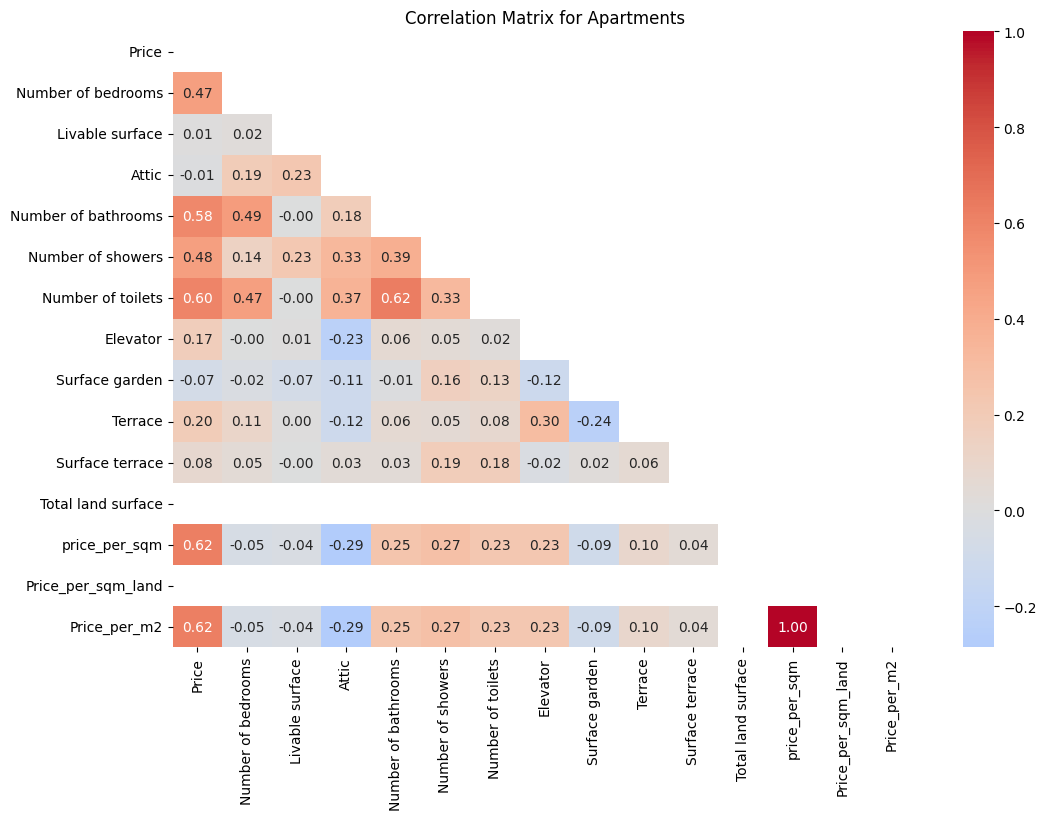

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

# Drop unwanted columns
apartments_clean = apartments.drop(columns=["Swimming pool", "Garden", "postal_code", "Number of facades", "Number of garages", "Furnished"])

# Select only numeric columns
numeric_cols = apartments_clean.select_dtypes(include='number').columns

# Compute correlation matrix
corr_matrix = apartments_clean[numeric_cols].corr()

# Correlation with Price
price_corr = corr_matrix['Price'].sort_values(ascending=False)
print(price_corr)

# Create upper-triangle mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, fmt=".2f",
            cmap='coolwarm', center=0)
plt.title("Correlation Matrix for Apartments")
plt.show()
